In [2]:
import os

# 路径
ucf_root = "/media/rh/Documents1/COMP8539/assignment2/datasets/UCF101/UCF-101"
split_root = "/media/rh/Documents1/COMP8539/assignment2/datasets/UCF101/ucfTrainTestlist"

# 读取类别索引
class2id = {}
with open(os.path.join(split_root, "classInd.txt"), "r") as f:
    for line in f:
        idx, name = line.strip().split()
        class2id[name] = int(idx)

# 读取 testlist01.txt
test_items = []
with open(os.path.join(split_root, "testlist01.txt"), "r") as f:
    for line in f:
        rel = line.strip()
        cls_name = rel.split("/")[0]   # 文件夹名就是类别
        cid = class2id[cls_name]
        test_items.append((os.path.join(ucf_root, rel), cid))

print("测试样本数:", len(test_items))
print("样例:", test_items[:3])


测试样本数: 3783
样例: [('/media/rh/Documents1/COMP8539/assignment2/datasets/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi', 1), ('/media/rh/Documents1/COMP8539/assignment2/datasets/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi', 1), ('/media/rh/Documents1/COMP8539/assignment2/datasets/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03.avi', 1)]


Original

In [ ]:
import os, re, random, numpy as np
import torch
from PIL import Image
from decord import VideoReader, cpu

from llava.model.builder import load_pretrained_model
from llava.constants import DEFAULT_IMAGE_TOKEN
from llava.conversation import conv_templates
from llava.mm_utils import tokenizer_image_token, IMAGE_TOKEN_INDEX

# -------------------
# 1. 加载模型
pretrained = "lmms-lab/llava-onevision-qwen2-0.5b-ov"
tokenizer, model, image_processor, _ = load_pretrained_model(
    pretrained, None, "llava_qwen",
    device_map="auto", attn_implementation="sdpa",
    multimodal=True
)
model.eval()

# -------------------
# 2. 数据路径
ucf_root = "/media/rh/Documents1/COMP8539/assignment2/datasets/UCF101/UCF-101"
split_root = "/media/rh/Documents1/COMP8539/assignment2/datasets/UCF101/ucfTrainTestlist"

# 类别表
class2id, id2class = {}, {}
with open(os.path.join(split_root, "classInd.txt")) as f:
    for line in f:
        idx, name = line.strip().split()
        idx = int(idx)
        class2id[name] = idx
        id2class[idx] = name

# 测试集
test_items = []
with open(os.path.join(split_root, "testlist01.txt")) as f:
    for line in f:
        rel = line.strip()
        cls = rel.split("/")[0]
        cid = class2id[cls]
        test_items.append((rel, cid))
print("Test samples:", len(test_items))   # 应该是 3783

# -------------------
# 3. 工具函数

def naturalize_label(name: str):
    """把 UCF101 类名变成更自然的短语"""
    words = re.findall(r"[A-Z][a-z]*|[A-Z]+", name)
    phrase = " ".join(w.lower() for w in words)
    phrase = phrase.replace(" eye make up"," eye makeup")
    if not phrase.startswith(("playing","performing","doing","applying","riding",
                              "swimming","running","walking")):
        phrase = "performing " + phrase
    return phrase

def make_prompt(options_natural):
    letters = list("ABCDEFGH")[:len(options_natural)]
    opts = " ".join([f"({l}) {o}." for l,o in zip(letters, options_natural)])
    prompt = (
        f"{DEFAULT_IMAGE_TOKEN}\n"
        "You are a vision-language assistant for video action recognition.\n"
        "Question: What action is happening in this video?\n"
        f"Options: {opts}\n"
        "Answer with the option letter only. Do not output anything else.\n"
        "Answer:"
    )
    return prompt, letters

def parse_letter(text, letters):
    m = re.search(r"\b([A-H])\b", text, flags=re.IGNORECASE)
    if m and m.group(1).upper() in letters:
        return m.group(1).upper()
    m = re.search(r"\(([A-H])\)", text, flags=re.IGNORECASE)
    if m and m.group(1).upper() in letters:
        return m.group(1).upper()
    return None

# -------------------
# 4. 推理函数

@torch.inference_mode()
def predict_full(rel_path, cid, k=8, return_true_pos=False, debug_return=False):
    import hashlib
    true_name = id2class[cid]
    # 每样本独立随机
    h = int(hashlib.md5(rel_path.encode()).hexdigest(), 16) % (2**32)
    rnd = random.Random(h)

    # 负类与选项
    negs = [v for v in id2class.values() if v != true_name]
    rnd.shuffle(negs)
    options_raw = [true_name] + negs[:k-1]
    rnd.shuffle(options_raw)
    # 自然化
    options_nat = [naturalize_label(x) for x in options_raw]

    # 视频与尺寸
    full_path = os.path.join(ucf_root, rel_path)
    vr = VideoReader(full_path, ctx=cpu(0))
    idxs = np.linspace(0, len(vr)-1, 16, dtype=int)
    frames = vr.get_batch(idxs).asnumpy()
    pil_frames = [Image.fromarray(fr) for fr in frames]
    image_sizes = [im.size for im in pil_frames]
    pixel_values = image_processor.preprocess(pil_frames, return_tensors="pt")["pixel_values"].half().to(model.device)
    images = [pixel_values]

    # Prompt + 图像token
    conv = conv_templates["qwen_1_5"].copy()
    prompt, letters = make_prompt(options_nat)
    conv.append_message(conv.roles[0], prompt)
    conv.append_message(conv.roles[1], None)
    input_ids = tokenizer_image_token(conv.get_prompt(), tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(model.device)

    # 生成
    out = model.generate(
        input_ids, images=images, image_sizes=image_sizes,
        do_sample=False, temperature=0.0, max_new_tokens=8, modalities=["video"]
    )
    text = tokenizer.decode(out[0], skip_special_tokens=True)

    # 解析
    pred_letter = parse_letter(text, letters)
    ok = False
    if pred_letter is not None:
        pred_idx = letters.index(pred_letter)
        ok = (options_raw[pred_idx] == true_name)

    # 返回调试信息
    if debug_return:
        return ok, {
            "letters": letters,
            "options_raw": options_raw,
            "options_nat": options_nat,
            "text": text,
            "pred_letter": pred_letter
        }
    if return_true_pos:
        true_pos = options_raw.index(true_name)  # 0->A,1->B...
        return ok, true_pos
    return ok


# 只评 Full-Decoding，按 10/20/30/40/50 打印中间结果
N = 50
acc_full = 0

for i, (rel, cid) in enumerate(test_items[:N], 1):
    ok_full = predict_full(rel, cid, k=16)   # 保持与 first-token 同一 k 与选项构造
    acc_full += int(ok_full)
    if i % 10 == 0 or i == N:
        print(f"[{i}/{N}] Acc_full={acc_full/i:.3f}")

print("Final Accuracy ({} samples): {:.3f}".format(N, acc_full/N))


Loaded LLaVA model: lmms-lab/llava-onevision-qwen2-0.5b-ov


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are using a model of type llava to instantiate a model of type llava_qwen. This is not supported for all configurations of models and can yield errors.


Loading vision tower: google/siglip-so400m-patch14-384
Model Class: LlavaQwenForCausalLM
Test samples: 3783
[10/50] Acc_full=0.600
[20/50] Acc_full=0.550
[30/50] Acc_full=0.633
[40/50] Acc_full=0.625
[50/50] Acc_full=0.620
Final Accuracy (50 samples): 0.620


First Token

In [ ]:
import torch.nn.functional as F

@torch.inference_mode()
def predict_first_token(rel_path, cid, k=16, debug_return=False):
    """
    First-Token probing 版本：
    - 仅解 1 个新 token（max_new_tokens=1）
    - 从首 token 的 logits 直接选择 A..Z 中哪个字母概率最高
    仅支持 k <= 26（单字符选项），否则请改两 token probing。
    """
    assert k <= 26, "First-token 方案仅支持单字符选项（k<=26）。如需32选，请改两token方案。"

    # ====== 与 predict() 一致的选项与语言风格 ======
    import hashlib
    true_name = id2class[cid]
    h = int(hashlib.md5(rel_path.encode()).hexdigest(), 16) % (2**32)
    rnd = random.Random(h)

    negs = [v for v in id2class.values() if v != true_name]
    rnd.shuffle(negs)
    options_raw = [true_name] + negs[:k-1]
    rnd.shuffle(options_raw)

    # 统一风格（你目前是 naturalize_label；若已改 normalize_label 也可）
    options_nat = [naturalize_label(x) for x in options_raw]

    # ====== 视频帧与预处理（与 predict 相同）======
    full_path = os.path.join(ucf_root, rel_path)
    vr = VideoReader(full_path, ctx=cpu(0))
    idxs = np.linspace(0, len(vr)-1, 16, dtype=int)
    frames = vr.get_batch(idxs).asnumpy()
    pil_frames = [Image.fromarray(fr) for fr in frames]
    image_sizes = [im.size for im in pil_frames]
    pixel_values = image_processor.preprocess(pil_frames, return_tensors="pt")["pixel_values"].half().to(model.device)
    images = [pixel_values]

    # ====== Prompt（A..Z 单字符）======
    letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")[:len(options_nat)]
    opts = " ".join([f"({l}) {o}." for l,o in zip(letters, options_nat)])
    prompt = (
        f"{DEFAULT_IMAGE_TOKEN}\n"
        "You are a vision-language assistant for video action recognition.\n"
        "Question: What action is happening in this video?\n"
        f"Options: {opts}\n"
        "Answer with the option letter only. Do not output anything else.\n"
        "Answer:"
    )
    from llava.mm_utils import tokenizer_image_token, IMAGE_TOKEN_INDEX
    conv = conv_templates["qwen_1_5"].copy()
    conv.append_message(conv.roles[0], prompt)
    conv.append_message(conv.roles[1], None)
    input_ids = tokenizer_image_token(conv.get_prompt(), tokenizer, IMAGE_TOKEN_INDEX,
                                      return_tensors="pt").unsqueeze(0).to(model.device)

    # ====== 仅生成 1 个 token，并拿首 token logits ======
    out = model.generate(
        input_ids,
        images=images, image_sizes=image_sizes,
        do_sample=False, temperature=0.0, top_p=1.0,
        max_new_tokens=1,
        return_dict_in_generate=True, output_scores=True,
        modalities=["video"],
    )
    # out.scores: List[logits at each generated step]; 这里只有一步
    logits = out.scores[0][0]          # (V,)
    probs  = F.softmax(logits, dim=-1) # (V,)

    # ====== 把字母映射到词表ID；必须是“单 token” ======
    letter_ids = []
    for l in letters:
        ids = tokenizer(l, add_special_tokens=False).input_ids
        if len(ids) != 1:
            # 理论上 A..Z 应该单token；若不是，直接报错，避免静默偏置
            raise ValueError(f"Letter {l} tokenizes to multiple ids: {ids}")
        letter_ids.append(ids[0])

    cand = torch.stack([probs[i] for i in letter_ids])  # (k,)
    pred_idx = int(torch.argmax(cand).item())
    ok = (options_raw[pred_idx] == true_name)

    if debug_return:
        return ok, {
            "letters": letters,
            "options_raw": options_raw,
            "options_nat": options_nat,
            "prob_per_letter": {l: float(cand[j]) for j,l in enumerate(letters)},
            "pred_letter": letters[pred_idx],
            "true_pos": options_raw.index(true_name)
        }
    return ok
# 小样本 sanity check：N 可先取 50/100
N = 50
acc_full = acc_first = agree = 0

for i, (rel, cid) in enumerate(test_items[:N], 1):
    ok_full = predict_full(rel, cid, k=16)                 # Full-decoding（确保 k<=26, 与 first 对齐）
    ok_first = predict_first_token(rel, cid, k=16)          # First-token probing
    acc_full += int(ok_full)
    acc_first += int(ok_first)
    agree += int(ok_full == ok_first)
    if i % 10 == 0:
        print(f"[{i}/{N}] Acc_full={acc_full/i:.3f}  Acc_first={acc_first/i:.3f}  Agreement={agree/i:.3f}")

print(f"Final: Acc_full={acc_full/N:.3f}  Acc_first={acc_first/N:.3f}  Agreement={agree/N:.3f}")


[10/50] Acc_full=0.600  Acc_first=0.900  Agreement=0.700
[20/50] Acc_full=0.550  Acc_first=0.900  Agreement=0.650
[30/50] Acc_full=0.633  Acc_first=0.933  Agreement=0.700
[40/50] Acc_full=0.625  Acc_first=0.925  Agreement=0.700
[50/50] Acc_full=0.620  Acc_first=0.900  Agreement=0.720
Final: Acc_full=0.620  Acc_first=0.900  Agreement=0.720


In [19]:
import os, hashlib, random, numpy as np, torch
import torch.nn.functional as F
from PIL import Image
from decord import VideoReader, cpu
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# —— 超参 ——
K = 16               # 每轮候选集大小 (<=26, 单字母)
M = 3                # 每个样本重复轮数，建议 3~5
FRAMES = 16          # 抽帧数
VERY_LOW = -1e9      # 对未出现类别的填充值（logit）

# —— 常用表 —— 
num_classes = 101
id_list = list(range(1, num_classes+1))     # 1..101
id2idx = {cid: (cid-1) for cid in id_list}   # 类别id -> [0..100]

# —— 将 one-round 首token logits 散射到 101 维向量 ——
def scatter_to_101(letter_logits, letters, options_raw):
    """
    letter_logits: Dict[letter] -> float (logit of that letter)
    letters: list like ["A","B",...]
    options_raw: list of class names (length K), 与 letters 对齐
    return: (101,) np.float32
    """
    vec = np.full((num_classes,), VERY_LOW, dtype=np.float32)
    for l, cls_name in zip(letters, options_raw):
        cid = class2id[cls_name]            # 1..101
        vec[id2idx[cid]] = float(letter_logits[l])
    return vec

# —— 构造候选集（与现有 predict() 相同的“样本级确定性随机”）——
def build_options(rel_path, true_name, K=16):
    h = int(hashlib.md5(rel_path.encode()).hexdigest(), 16) % (2**32)
    rnd = random.Random(h)
    negs = [n for n in id2class.values() if n != true_name]
    rnd.shuffle(negs)
    options_raw = [true_name] + negs[:K-1]
    rnd.shuffle(options_raw)
    letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")[:K]
    return options_raw, letters

# —— 一轮：取首 token logits（未softmax），映射到字母 —— 
@torch.inference_mode()
def first_token_letter_logits(frames, letters, prompt):
    # 构图像输入
    pil_frames = [Image.fromarray(fr) for fr in frames]
    image_sizes = [im.size for im in pil_frames]
    pixel_values = image_processor.preprocess(pil_frames, return_tensors="pt")["pixel_values"].half().to(model.device)
    images = [pixel_values]

    # 构输入 ids（带 <image>）
    conv = conv_templates["qwen_1_5"].copy()
    conv.append_message(conv.roles[0], prompt)
    conv.append_message(conv.roles[1], None)
    input_ids = tokenizer_image_token(conv.get_prompt(), tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(model.device)

    out = model.generate(
        input_ids,
        images=images, image_sizes=image_sizes,
        do_sample=False, temperature=0.0, top_p=1.0,
        max_new_tokens=1,
        return_dict_in_generate=True, output_scores=True,
        modalities=["video"],
    )
    logits = out.scores[0][0]                # (V,)
    # 取每个字母的logit（必须是单 token）
    letter_ids = []
    for l in letters:
        ids = tokenizer(l, add_special_tokens=False).input_ids
        assert len(ids) == 1, f"Letter {l} not single-token: {ids}"
        letter_ids.append(ids[0])
    vals = {l: float(logits[i].item()) for l,i in zip(letters, letter_ids)}
    return vals

def make_prompt(options_nat):
    letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")[:len(options_nat)]
    opts = " ".join([f"({l}) {o}." for l,o in zip(letters, options_nat)])
    prompt = (
        f"{DEFAULT_IMAGE_TOKEN}\n"
        "You are a vision-language assistant for video action recognition.\n"
        "Question: What action is happening in this video?\n"
        f"Options: {opts}\n"
        "Answer with the option letter only. Do not output anything else.\n"
        "Answer:"
    )
    return prompt, letters

# 统一风格（可用你已有的 naturalize_label/normalize_label）
import re
def normalize_label(name: str):
    toks = re.findall(r"[A-Z][a-z]*|[A-Z]+", name)
    phrase = " ".join(t.lower() for t in toks)
    phrase = phrase.replace(" eye make up"," eye makeup")
    return "doing " + phrase

def sample_frames(vid_path, n=FRAMES):
    vr = VideoReader(vid_path, ctx=cpu(0))
    idxs = np.linspace(0, len(vr)-1, n, dtype=int)
    return vr.get_batch(idxs).asnumpy()

def extract_features(items, split_name="train"):
    X, y = [], []
    for rel, cid in tqdm(items, desc=f"feat-{split_name}", ncols=100):
        vid_path = os.path.join(ucf_root, rel)
        frames = sample_frames(vid_path, FRAMES)
        # 聚合 M 轮
        vecs = []
        for m in range(M):
            # 为了每轮不同候选：在 path 基础上叠加轮次 seed
            rel_m = rel + f"#r{m}"
            # 构候选
            true_name = id2class[cid]
            options_raw, letters = build_options(rel_m, true_name, K=K)
            options_nat = [normalize_label(x) for x in options_raw]
            prompt, letters = make_prompt(options_nat)
            # 一轮首token logits
            lt = first_token_letter_logits(frames, letters, prompt)   # Dict[l] -> logit
            # 散射到101维
            v = scatter_to_101(lt, letters, options_raw)              # (101,)
            vecs.append(v)
        feat = np.stack(vecs, axis=0).mean(axis=0)                    # (101,)
        X.append(feat)
        y.append(cid-1)  # 0..100
    X = np.stack(X, axis=0).astype(np.float32)
    y = np.array(y, dtype=np.int64)
    return X, y

# —— 构造 train/test 列表（用官方 split01）——
train_items = []
with open(os.path.join(split_root, "trainlist01.txt")) as f:
    for line in f:
        rel, cid = line.strip().split()
        train_items.append((rel, int(cid)))

test_items = []
with open(os.path.join(split_root, "testlist01.txt")) as f:
    for line in f:
        rel = line.strip()
        cls = rel.split("/")[0]
        cid = class2id[cls]
        test_items.append((rel, cid))

print("Train:", len(train_items), " Test:", len(test_items))

# —— 抽取并保存特征 ——（可分两次运行以防崩）
X_tr, y_tr = extract_features(train_items, "train")
X_te, y_te = extract_features(test_items,  "test")

np.savez("/media/rh/Documents1/COMP8539/assignment2/LLaVA-NeXT/ft_lp_ucf101_k16_m3.npz",
         X_tr=X_tr, y_tr=y_tr, X_te=X_te, y_te=y_te)
print("saved npz:", X_tr.shape, X_te.shape)


Train: 9537  Test: 3783


feat-train:   0%|                                                          | 0/9537 [00:00<?, ?it/s]/home/rh/miniconda3/envs/llava/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/rh/miniconda3/envs/llava/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:509: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
feat-test: 100%|██████████████████████████████████████████████| 3783/3783 [3:00:48<00:00,  2.87s/it]

saved npz: (9537, 101) (3783, 101)


In [20]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

data = np.load("/media/rh/Documents1/COMP8539/assignment2/LLaVA-NeXT/ft_lp_ucf101_k16_m3.npz")
X_tr, y_tr, X_te, y_te = data["X_tr"], data["y_tr"], data["X_te"], data["y_te"]
print("features:", X_tr.shape, X_te.shape)  # (N, 101)

# 标准化（可选）；这里直接用原始logits通常已可
# 训练 multinomial LR
clf = LogisticRegression(
    penalty="l2", C=1.0, max_iter=300,
    multi_class="multinomial", solver="lbfgs", n_jobs=-1
)
clf.fit(X_tr, y_tr)

pred = clf.predict(X_te)
acc = accuracy_score(y_te, pred)
print(f"[Linear Probing @ K={K}, M={M}]  Test Accuracy = {acc:.3f}")
  

features: (9537, 101) (3783, 101)
[Linear Probing @ K=16, M=3]  Test Accuracy = 0.850


Train shape: (9537, 101)  Test shape: (3783, 101)
Classes: 101
Test Accuracy: 0.850

Classification Report (前10类示例):
              precision    recall  f1-score   support

           0      0.864     0.864     0.864        44
           1      0.750     0.844     0.794        32
           2      0.829     0.829     0.829        41
           3      0.900     0.771     0.831        35
           4      0.812     0.839     0.825        31
           5      0.860     0.860     0.860        43
           6      0.930     0.930     0.930        43
           7      0.938     0.857     0.896        35
           8      0.838     0.838     0.838        37
           9      0.933     0.875     0.903        48
          10      0.829     0.895     0.861        38
          11      0.875     0.875     0.875        40
          12      0.739     0.895     0.810        38
          13      0.839     0.788     0.812        33
          14      0.828     0.800     0.814        30
          15      

/home/rh/miniconda3/envs/llava/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rh/miniconda3/envs/llava/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rh/miniconda3/envs/llava/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rh/miniconda3/envs/llava/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35270 (\N{CJK UNIFIED IDEOGRAPH-89C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rh/miniconda3/envs/llava/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: User

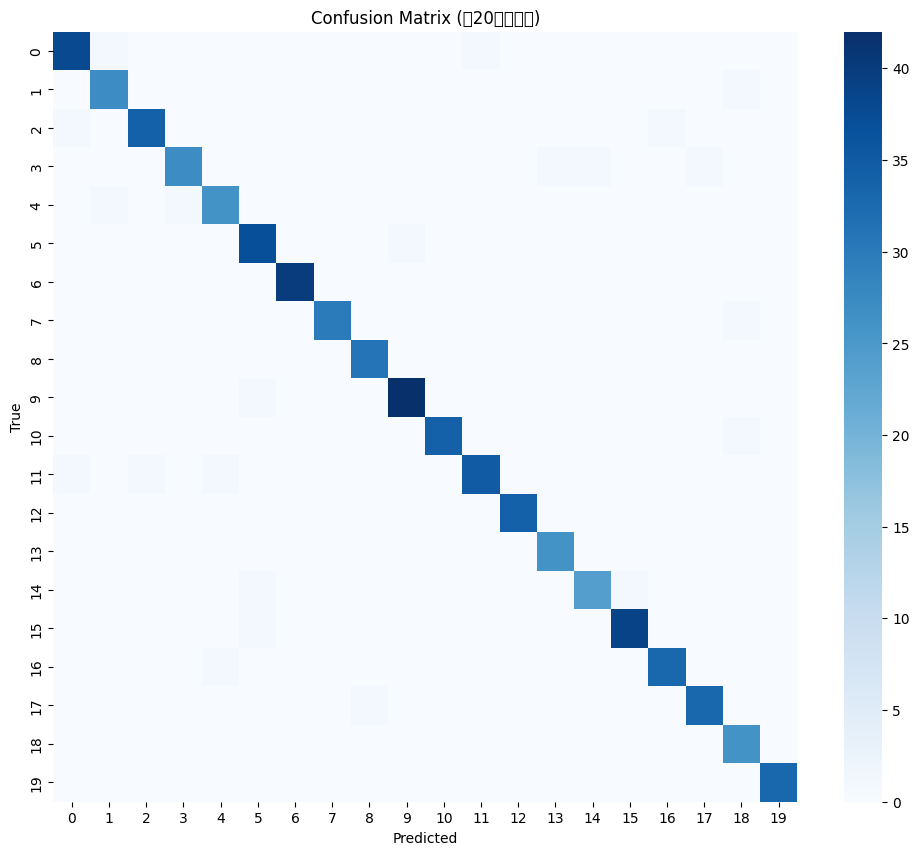

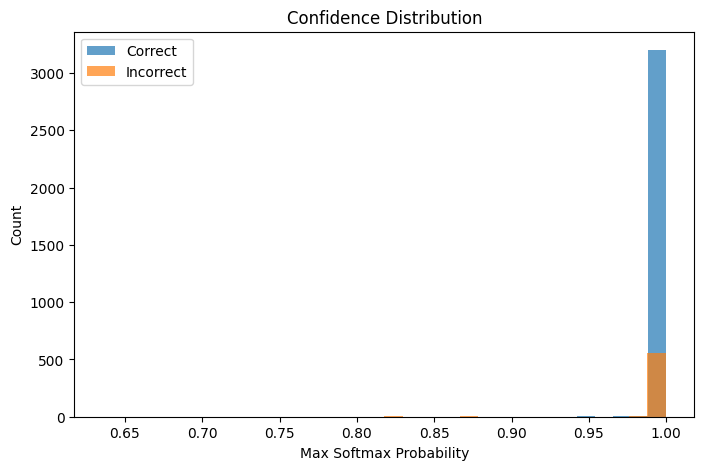

In [23]:
# First-Token Linear Probing 分析
# 使用保存好的 npz 文件进行结果分析

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# --------------------
# 1. 加载数据
data = np.load("/media/rh/Documents1/COMP8539/assignment2/LLaVA-NeXT/ft_lp_ucf101_k16_m3.npz")
X_tr, y_tr, X_te, y_te = data["X_tr"], data["y_tr"], data["X_te"], data["y_te"]

print("Train shape:", X_tr.shape, " Test shape:", X_te.shape)
print("Classes:", len(np.unique(y_tr)))

# --------------------
# 2. 训练线性分类器 (Logistic Regression)
clf = LogisticRegression(max_iter=2000, solver="lbfgs", multi_class="multinomial", n_jobs=-1)
clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)

acc = accuracy_score(y_te, y_pred)
print(f"Test Accuracy: {acc:.3f}")

# --------------------
# 3. 分类报告 (per-class accuracy, precision, recall)
print("\nClassification Report (前10类示例):")
print(classification_report(y_te, y_pred, digits=3)[:1000])  # 打印前1000字符避免太长

# --------------------
# 4. 混淆矩阵
cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm[:20, :20], annot=False, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (前20类可视化)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --------------------
# 5. 置信度分布分析
probs = clf.predict_proba(X_te)
conf_max = probs.max(axis=1)

plt.figure(figsize=(8,5))
plt.hist(conf_max[y_pred==y_te], bins=30, alpha=0.7, label="Correct")
plt.hist(conf_max[y_pred!=y_te], bins=30, alpha=0.7, label="Incorrect")
plt.title("Confidence Distribution")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Count")
plt.legend()
plt.show()


In [24]:
# UCF101 - First-Token Linear Probing: 深度分析
# 修改为你的 npz 路径
npz_path = "/media/rh/Documents1/COMP8539/assignment2/LLaVA-NeXT/ft_lp_ucf101_k16_m3.npz"

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

data = np.load(npz_path)
X_tr, y_tr, X_te, y_te = data["X_tr"], data["y_tr"], data["X_te"], data["y_te"]
num_classes = X_tr.shape[1]
print("Train shape:", X_tr.shape, " Test shape:", X_te.shape, " num_classes:", num_classes)

clf = LogisticRegression(
    penalty="l2", C=1.0, max_iter=300,
    multi_class="multinomial", solver="lbfgs", n_jobs=-1
)
clf.fit(X_tr, y_tr)

y_pred = clf.predict(X_te)
print(f"Test Accuracy: {accuracy_score(y_te, y_pred):.3f}")

# 长报告（如需完整打印可移除 [:1000]）
print("\nClassification Report (部分):")
print(classification_report(y_te, y_pred, digits=3)[:1000])


Train shape: (9537, 101)  Test shape: (3783, 101)  num_classes: 101
Test Accuracy: 0.850

Classification Report (部分):
              precision    recall  f1-score   support

           0      0.864     0.864     0.864        44
           1      0.750     0.844     0.794        32
           2      0.829     0.829     0.829        41
           3      0.900     0.771     0.831        35
           4      0.812     0.839     0.825        31
           5      0.860     0.860     0.860        43
           6      0.930     0.930     0.930        43
           7      0.938     0.857     0.896        35
           8      0.838     0.838     0.838        37
           9      0.933     0.875     0.903        48
          10      0.829     0.895     0.861        38
          11      0.875     0.875     0.875        40
          12      0.739     0.895     0.810        38
          13      0.839     0.788     0.812        33
          14      0.828     0.800     0.814        30
          15     

In [25]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

acc = accuracy_score(y_te, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_te, y_pred, average="macro", zero_division=0
)

probs = clf.predict_proba(X_te)
y_te_bin = label_binarize(y_te, classes=np.arange(num_classes))
try:
    auroc_macro = roc_auc_score(y_te_bin, probs, average="macro", multi_class="ovr")
except Exception:
    auroc_macro = float("nan")

print(f"Accuracy: {acc:.3f}")
print(f"Macro Precision: {prec_macro:.3f}")
print(f"Macro Recall: {rec_macro:.3f}")
print(f"Macro F1: {f1_macro:.3f}")
print(f"Macro AUROC (OvR): {auroc_macro:.3f}")


Accuracy: 0.850
Macro Precision: 0.851
Macro Recall: 0.849
Macro F1: 0.848
Macro AUROC (OvR): 0.999


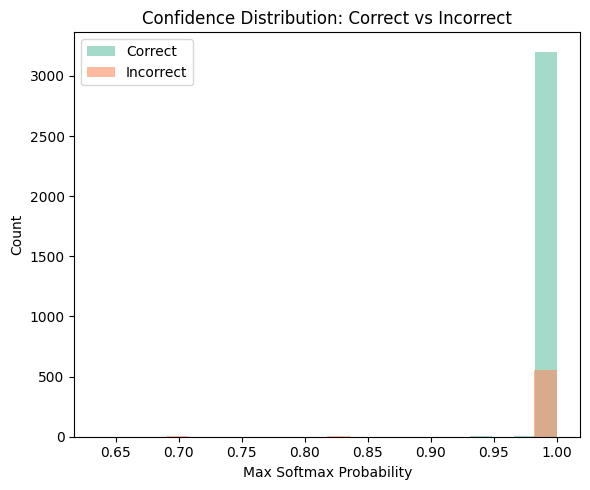

In [31]:
# 安装一次即可（若已装过可跳过）
# !pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

conf_max = probs.max(axis=1)
mask_correct = (y_pred == y_te)

plt.figure(figsize=(6,5))
plt.hist(conf_max[mask_correct], bins=20, alpha=0.6, label="Correct", color="#66c2a5")
plt.hist(conf_max[~mask_correct], bins=20, alpha=0.6, label="Incorrect", color="#fc8d62")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Count")
plt.title("Confidence Distribution: Correct vs Incorrect")
plt.legend()
plt.tight_layout()
plt.savefig("ucf101_confidence_hist.png", dpi=300)
plt.show()



In [27]:
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

cm = confusion_matrix(y_te, y_pred, labels=np.arange(num_classes))  # (C,C)
tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
fn = cm.sum(axis=1) - tp
tn = cm.sum() - (tp + fp + fn)

per_prec, per_rec, per_f1, per_sup = precision_recall_fscore_support(
    y_te, y_pred, average=None, labels=np.arange(num_classes), zero_division=0
)

df_perclass = pd.DataFrame({
    "class_id": np.arange(num_classes),
    "TP": tp, "FP": fp, "TN": tn, "FN": fn,
    "Precision": per_prec,
    "Recall": per_rec,
    "F1": per_f1,
    "Support": per_sup
}).sort_values(by="F1", ascending=False)

# 预览前 20 类
df_perclass.head(20)
# 保存完整 CSV（PPT 可引用）
df_perclass.to_csv("ucf101_lp_perclass_metrics.csv", index=False)
print("Saved: ucf101_lp_perclass_metrics.csv")


Saved: ucf101_lp_perclass_metrics.csv


In [29]:
bins = [0.0, 0.5, 0.8, 1.0]
labels = ["low(0-0.5)", "mid(0.5-0.8)", "high(0.8-1.0)"]
bucket = np.digitize(conf_max, bins) - 1

print("\n=== Accuracy by Confidence Bucket ===")
for i, name in enumerate(labels):
    idx = (bucket == i)
    acc_bin = float((y_pred[idx] == y_te[idx]).mean()) if idx.sum() > 0 else float("nan")
    print(f"{name}: {acc_bin:.3f}  (n={idx.sum()})")



=== Accuracy by Confidence Bucket ===
low(0-0.5): nan  (n=0)
mid(0.5-0.8): 0.222  (n=9)
high(0.8-1.0): 0.491  (n=214)


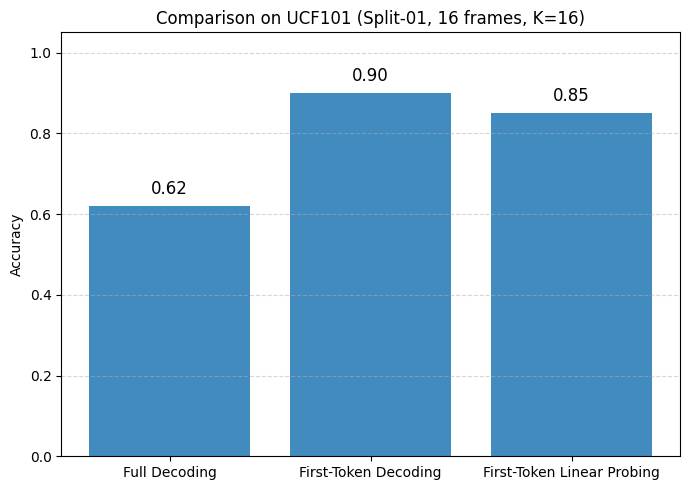

In [30]:
import matplotlib.pyplot as plt

methods = ["Full Decoding", "First-Token Decoding", "First-Token Linear Probing"]
accuracy = [0.62, 0.90, 0.85]

plt.figure(figsize=(7,5))
bars = plt.bar(methods, accuracy, alpha=0.85)
for b,a in zip(bars, accuracy):
    plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.02, f"{a:.2f}", ha="center", va="bottom", fontsize=12)
plt.ylim(0,1.05)
plt.ylabel("Accuracy")
plt.title("Comparison on UCF101 (Split-01, 16 frames, K=16)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("ucf101_method_comparison.png", dpi=300)
plt.show()


In [ ]:
examples = []

for i, (rel, cid) in enumerate(test_items[:100]):  # 先跑前100个，方便调试
    ok_full = predict_full(rel, cid, k=16)
    ok_first = predict_first_token(rel, cid, k=16)
    ok_lp = predict_linear_probing(rel, cid)

    if (not ok_full) and ok_first and ok_lp:
        examples.append((rel, cid))
        print("Found example:", rel, "Class:", id2class[cid])
        if len(examples) >= 5:  # 找几个备选
            break
